(assignment08)=


# Assignment #8 (demo). Implementation of online regressor

<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />

**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Yury Kashnitsky](https://yorko.github.io). Translated by [Sergey Oreshkov](https://www.linkedin.com/in/sergeoreshkov/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

**Same assignment as a [Kaggle Notebook](https://www.kaggle.com/kashnitsky/a8-demo-implementing-online-regressor) + [solution](https://www.kaggle.com/kashnitsky/a8-demo-implementing-online-regressor-solution).**

Here we'll implement a regressor trained with stochastic gradient descent (SGD). Fill in the missing code. If you do everything right, you'll pass a simple embedded test.

## Linear regression and Stochastic Gradient Descent

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Implement class `SGDRegressor`. Specification:
- class is inherited from `sklearn.base.BaseEstimator`
- constructor takes parameters `eta` – gradient step ($10^{-3}$ by default) and `n_epochs` – dataset pass count (3 by default)
- constructor also creates `mse_` and `weights_` lists in order to track mean squared error and weight vector during gradient descent iterations
- Class has `fit` and `predict` methods
- The `fit` method takes matrix `X` and vector `y` (`numpy.array` objects) as parameters, appends column of ones to  `X` on the left side, initializes weight vector `w` with **zeros** and then makes `n_epochs` iterations of weight updates (you may refer to this [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-8-vowpal-wabbit-fast-learning-with-gigabytes-of-data-60f750086237) for details), and for every iteration logs mean squared error and weight vector `w` in corresponding lists we created in the constructor.
- Additionally the `fit` method will create `w_` variable to store weights which produce minimal mean squared error
- The `fit` method returns current instance of the `SGDRegressor` class, i.e. `self`
- The `predict` method takes `X` matrix, adds column of ones to the left side and returns prediction vector, using weight vector `w_`, created by the `fit` method.

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_epochs=3):
        self.eta = eta
        self.n_epochs = n_epochs
        self.mse_ = []
        self.weights_ = []

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]

        return self

    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        return X.dot(self.w_)

Let's test out the algorithm on height/weight data. We will predict heights (in inches) based on weights (in lbs).

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [4]:
data_demo = pd.read_csv(DATA_PATH + "weights_heights.csv")

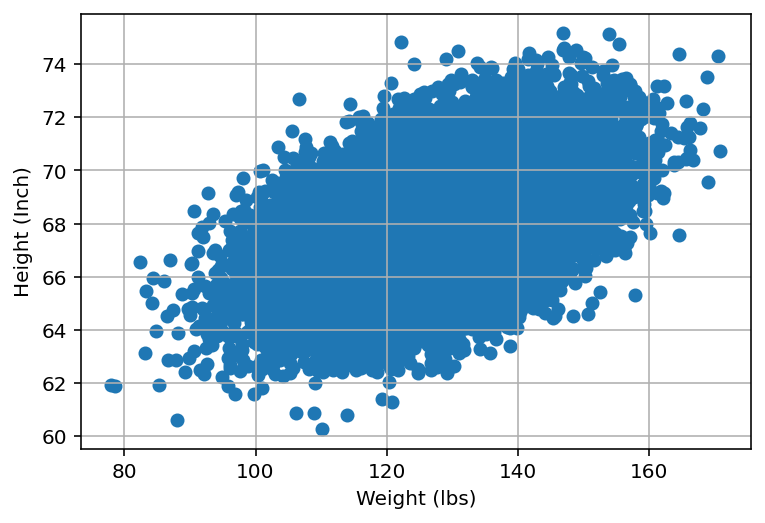

In [5]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (Inch)")
plt.grid()

In [6]:
data_demo.head()

Index    Height    Weight
0      1  65.78331  112.9925
1      2  71.51521  136.4873
2      3  69.39874  153.0269
3      4  68.21660  142.3354
4      5  67.78781  144.2971

In [7]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

Perform train/test split and scale data.

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([-1, 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([-1, 1]))

Train created `SGDRegressor` with `(X_train_scaled, y_train)` data. Leave default parameter values for now.

In [10]:
sgd = SGDRegressor()
sgd.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:16<00:00,  5.57s/it]


SGDRegressor()

Draw a chart with training process  – dependency of mean squared error from the i-th SGD iteration number.

Text(0, 0.5, 'MSE')

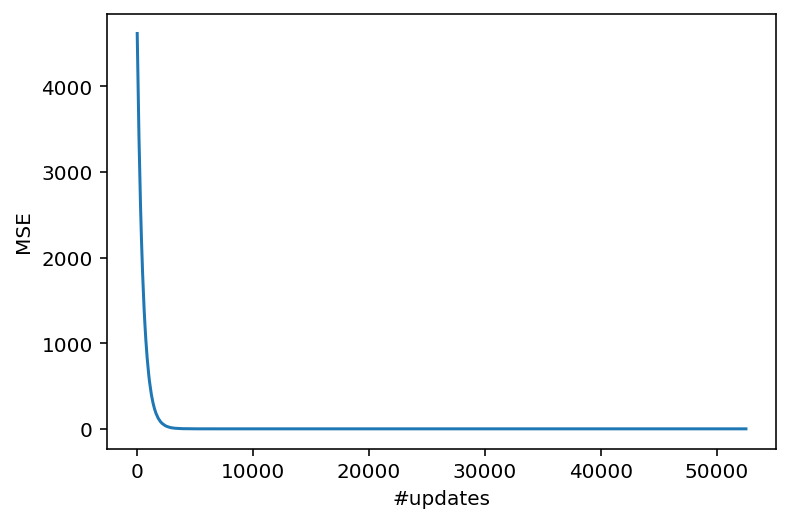

In [11]:
plt.plot(range(len(sgd.mse_)), sgd.mse_)
plt.xlabel("#updates")
plt.ylabel("MSE")

Print the minimal value of mean squared error and the best weights vector.

In [12]:
np.min(sgd.mse_), sgd.w_

(2.7151352406643623, array([67.9898497 ,  0.94447605]))

Draw chart of model weights ($w_0$ and $w_1$) behavior during training.

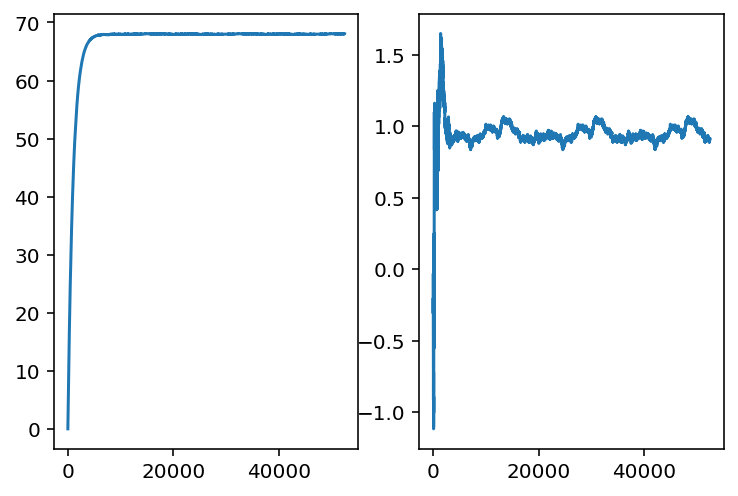

In [13]:
plt.subplot(121)
plt.plot(range(len(sgd.weights_)), [w[0] for w in sgd.weights_])
plt.subplot(122)
plt.plot(range(len(sgd.weights_)), [w[1] for w in sgd.weights_])

Make a prediction for hold-out  set `(X_valid_scaled, y_valid)` and check MSE value.

In [15]:
sgd_holdout_mse = mean_squared_error(y_valid, sgd.predict(X_valid_scaled))
sgd_holdout_mse

2.6708681207033784

Do the same thing for `LinearRegression` class from `sklearn.linear_model`. Evaluate MSE for hold-out set.

In [16]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train_scaled, y_train)
print(lm.coef_, lm.intercept_)
linreg_holdout_mse = mean_squared_error(y_valid, lm.predict(X_valid_scaled))
linreg_holdout_mse

[0.94537278] 67.98930834742858


2.670830767667635

In [17]:
try:
    assert (sgd_holdout_mse - linreg_holdout_mse) < 1e-4
    print("Correct!")
except AssertionError:
    print(
        "Something's not good.\n Linreg's holdout MSE: {}"
        "\n SGD's holdout MSE: {}".format(linreg_holdout_mse, sgd_holdout_mse)
    )

Correct!
